# Imports

In [1]:
import keras
import numpy as np
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.io import wavfile

from sklearn.metrics import accuracy_score, hamming_loss, zero_one_loss, auc

from bokeh.plotting import figure, show
from bokeh.io import output_notebook

from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
import random

from keras.layers import Conv1D, MaxPool1D, Activation, Dense, Input, Flatten, BatchNormalization, Dropout
from keras.losses import binary_crossentropy
from keras.optimizers import SGD
from keras.utils import Sequence
import keras.backend as K
import tensorflow as tf

/home/emanuele.dallalonga/miniconda3/envs/musictagger/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Functions

###### Data reading during training

In [2]:
class MagnaTagATuneSequence(Sequence):

    def __init__(self, train_set_paths, train_set_labels, batch_size, mode):
        self.paths, self.y = train_set_paths, train_set_labels
        self.batch_size = batch_size
        self.mode = mode
        
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x_paths = self.paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_x = []
        for value in batch_x_paths:
            path = '../data/MagnaTagATune/rawwav/'+value[:-3]+'wav'
            _, data = wavfile.read(path)
            batch_x.append(data)
        batch_x = np.array(batch_x)[:,:,np.newaxis]
        if (self.mode == 'test'):
            return (batch_x)
        elif (self.mode == 'train'):
            return (batch_x,batch_y)   
        else:
            return false

###### Performance Metrics

In [3]:
def ratio_wrong_over_correct_ones(y_true, y_pred):
    op1 = K.sum(K.abs(K.cast(y_true - K.round(y_pred), dtype='float32')))
    op2 = K.sum(K.cast(K.equal(y_true,1.0),dtype='float32'))
    return op1/op2

def ratio_correct_ones(y_true, y_pred):
    op1 = K.sum(K.cast(K.equal(y_true + K.round(y_pred),2.0),dtype='float32'))
    op2 = K.sum(K.cast(K.equal(y_true,1.0),dtype='float32'))
    return op1/op2

def auc_roc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred, summation_method='careful_interpolation')

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc_roc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
        return value    

###### Best checkpoint selection

In [4]:
def find_best_checkpoint(prev_chkpts):
    best_ratio = 0
    best_chkpt = ''
    best_epoch = 0
    for chkpt in prev_chkpts:
        epoch = int(chkpt[8:11])
        ratio = float(chkpt[12:19])
        
        if ratio > best_ratio:
            best_ratio = ratio
            best_chkpt = chkpt
            best_epoch = epoch
    print('\n starting from model {} \n'.format(best_chkpt))
    return best_chkpt, best_epoch

# Training

###### Prepare Training and Validation  Sets

In [5]:
annotations_path = '../data/MagnaTagATune/annotation_reduced.csv'
annotations = pd.read_csv(annotations_path, sep='\t')
train_set, test_set = train_test_split(annotations['mp3_path'], train_size=0.8, test_size=0.2, random_state=12345) 
test_set, val_set = train_test_split(test_set, train_size=0.3, test_size=0.7, random_state=12345) 
#train_set= train_set.loc[train_set.str.len()<70]
#test_set= test_set.loc[test_set.str.len()<70]

train_set_paths = train_set.values
train_set_labels = annotations.loc[annotations['mp3_path'].isin(train_set)].drop(columns=['mp3_path','Unnamed: 0']).values
train_set_size = len(train_set_paths)
print("Train set size: {} \n".format(train_set_size))

y_dimension = train_set_labels.shape[1]

_, data = wavfile.read( '../data/MagnaTagATune/rawwav_2/' + annotations['mp3_path'][0][:-3]+ 'wav')
x_dimension = len(data)

print("X dimension: {}\nY dimension: {} \n".format(x_dimension, y_dimension))

val_set_paths = val_set.values
val_set_labels = annotations.loc[annotations['mp3_path'].isin(val_set)].drop(columns=['mp3_path','Unnamed: 0']).values
val_set_size = len(val_set_paths)
print("Validation set size: {} \n".format(val_set_size))

Train set size: 20688 

X dimension: 465984
Y dimension: 40 

Validation set size: 3621 



In [10]:
train_split = 0.7
batch_size = 32
num_songs = len(annotations)*train_split
train_set_percent = int(num_songs - num_songs%batch_size)
train_set_percent/len(annotations)

0.6991492652745553

###### Modify session

In [7]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
keras.backend.set_session(session)

######  Building Model

In [8]:
model = keras.Sequential()

model.add(Conv1D(filters=128, kernel_size=3, strides=3, padding='valid', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv1D(filters=128, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=256, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Conv1D(filters=512, kernel_size=3, strides=1, padding='same', input_shape=(x_dimension,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool1D(pool_size=3))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(units=y_dimension, activation='sigmoid'))

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 155328, 128)       512       
_________________________________________________________________
batch_normalization_1 (Batch (None, 155328, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 155328, 128)       0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 155328, 128)       49280     
_________________________________________________________________
batch_normalization_2 (Batch (None, 155328, 128)       512       
_________________________________________________________________
activation_2 (Activation)    (None, 155328, 128)       0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 51776, 128)        0         
__________

###### Parameters

In [10]:
#Training Parameters
max_epochs = 200
max_trainings = 10

# SGD parameters
starting_learning_rate = 0.01
momentum = 0.9
starting_decay = 1e-6

# EarlyStopping Parameters
min_improvement = 0
patience = 5

# Directories
checkpoint_dir = './checkpoints_nan/'
if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
checkpoint_file_name = 'weights-{epoch:03d}-{val_loss:.5f}-{val_auc_roc:.5f}.hdf5'
log_dir ='./logs'

###### Callbacks definition

In [11]:
class MyCallBack(keras.callbacks.Callback):
    def __init__(self, callbacks,model):
            super().__init__()
            self.callback = callbacks
            self.model = model
            self.model_original = model

    def on_epoch_begin(self,epoch,logs=None):
            self.model = self.model_original
            self.callback.on_epoch_begin(epoch, logs=logs)

    def on_epoch_end(self,epoch,logs=None):
            self.model = self.model_original
            self.callback.on_epoch_end(epoch, logs=logs)

    def on_batch_end(self, batch, logs=None):
            self.model = self.model_original
            self.callback.on_batch_end(batch, logs=logs)

    def on_batch_begin(self, batch, logs=None):
            self.model = self.model_original
            self.callback.on_batch_begin(batch, logs=logs)

    def on_train_begin(self, logs=None):
            self.model = self.model_original
            self.callback.set_model(self.model)
            self.callback.on_train_begin(logs=logs)

    def on_train_end(self, logs=None):
            self.model = self.model_original
            self.callback.on_train_end(logs=logs)

cbk_tb = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=batch_size, write_graph=True,
                                         write_grads=False, write_images=False, embeddings_freq=0,
                                         embeddings_layer_names=None, embeddings_metadata=None)

cbk_es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='max',
                                          min_delta=min_improvement, patience=patience, verbose=1)

cbk_mc = keras.callbacks.ModelCheckpoint(monitor='val_loss', mode='max', save_best_only=True, 
                                            filepath=checkpoint_dir+checkpoint_file_name, 
                                            verbose=1)

cbk = MyCallBack(cbk_tb, model)
cbk1 = MyCallBack(cbk_es, model)
cbk2 = MyCallBack(cbk_mc, model)

callbacks = [cbk,cbk1,cbk2]

###### Training

In [33]:
initial_epoch = 0
training_nr = 0

decay = 1e-5
learning_rate = 0.05

parallel_model = keras.utils.multi_gpu_model(model, gpus=n_gpus)

while (initial_epoch <= max_epochs) and (training_nr <= max_trainings):
    print('\n\n* * * * Starting training {0} from epoch {1} * * * * \n\n'.format(training_nr,  initial_epoch+1))
    best_checkpoint = ''
    best_epoch = 0
    
    previous_checkpoints = os.listdir(checkpoint_dir)
    
    if previous_checkpoints != []:
        best_checkpoint, best_epoch = find_best_checkpoint(previous_checkpoints)
        initial_epoch = best_epoch      
       
    if training_nr != 0:
        if training_nr == 1:
            decay = starting_decay
            learning_rate = starting_learning_rate
        else:
            decay = starting_decay ** training_nr
            learning_rate = starting_learning_rate - decay 
                
                
        
    training_nr = training_nr + 1
    
    optimizer = SGD(lr = learning_rate, momentum = momentum, decay = decay , nesterov=True)
    parallel_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[ratio_correct_ones,
                                                                            ratio_wrong_over_correct_ones,
                                                                            auc_roc]) 
    
    if len(previous_checkpoints)!=0:
        model.load_weights(checkpoint_dir + best_checkpoint)
        parallel_model = keras.utils.multi_gpu_model(model, gpus=n_gpus)
    
    
    parallel_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[ratio_correct_ones,
                                                                            ratio_wrong_over_correct_ones,
                                                                            auc_roc]) 

    parallel_model.fit_generator(MagnaTagATuneSequence(train_set_paths, train_set_labels, batch_size, 'train'),
                        validation_data = MagnaTagATuneSequence(val_set_paths, val_set_labels, batch_size, 'train'),
                        epochs=max_epochs, callbacks = callbacks, initial_epoch = initial_epoch)



* * * * Starting training 0 from epoch 1 * * * * 


Epoch 1/200
 289/2069 [===>..........................] - ETA: 27:48 - loss: 0.4965 - ratio_correct_ones: 0.0299 - ratio_wrong_over_correct_ones: 1.1847 - auc_roc: 0.5626

KeyboardInterrupt: 

# Model Testing

###### Prepare Test Set

In [12]:
test_set_paths = test_set.values
test_set_labels = annotations.loc[annotations['mp3_path'].isin(test_set)].drop(columns=['mp3_path','Unnamed: 0']).values
test_set_size = len(test_set_paths)
print("Test set size: {} ".format(test_set_size))

Test set size: 1551 


###### Load best Model

In [17]:
checkpoint_dir = './checkpoints/'
previous_checkpoints = sorted(os.listdir(checkpoint_dir))
parallel_model = keras.utils.multi_gpu_model(model, gpus=n_gpus)
#best_checkpoint, best_epoch = find_best_checkpoint(previous_checkpoints)
#model.load_weights(checkpoint_dir + best_checkpoint)
selected_checkpoint = previous_checkpoints[0]
model.load_weights(checkpoint_dir + selected_checkpoint)
print('Using checkpoint '+selected_checkpoint)

Using checkpoint weights-001-0.59733.hdf5


###### Prediction and evaluation

In [98]:
predictions = parallel_model.predict_generator(MagnaTagATuneSequence(test_set_paths, test_set_labels, 5, 'test'), verbose=1)
predictions

26/26 [==============================] - 12s 450ms/step


array([[0.01878935, 0.01852017, 0.02048917, ..., 0.14558192, 0.16855632,
        0.18662281],
       [0.01878935, 0.01852017, 0.02048917, ..., 0.14558192, 0.16855632,
        0.18662281],
       [0.01878935, 0.01852017, 0.02048917, ..., 0.14558192, 0.16855632,
        0.18662281],
       ...,
       [0.01878935, 0.01852017, 0.02048917, ..., 0.14558192, 0.16855632,
        0.18662281],
       [0.01878935, 0.01852017, 0.02048917, ..., 0.14558192, 0.16855632,
        0.18662281],
       [0.01878935, 0.01852017, 0.02048917, ..., 0.14558192, 0.16855632,
        0.18662281]], dtype=float32)

[0.28952363, 0.28734705, 0.28945398, ..., 0.29674158, 0.30383506,
        0.3111732 ]
        
[0.04875409, 0.04846902, 0.05011917, ..., 0.15107952, 0.1723044 ,
        0.18968451]
        
[0.01878935, 0.01852017, 0.02048917, ..., 0.14558192, 0.16855632,
        0.18662281]

In [101]:
test = predictions[0]
print("All the same: {}".format(all([all(i) for i in [test-i<np.finfo(np.float32).eps for i in predictions]])))

All the same: True


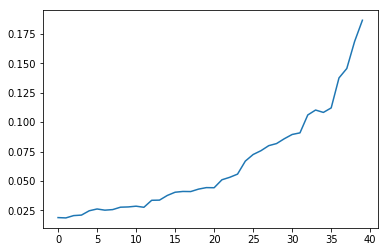

In [102]:
plt.plot( list(range(0,predictions.shape[1])), predictions[0])

seq = MagnaTagATuneSequence(test_set_paths, test_set_labels, batch_size, 'test')
song = seq[1]
print(song)

In [47]:
try:
    roc_auc = roc_auc_score(test_set_labels, predictions)
    print("Test roc auc result: {} ".format(roc_auc))
except ValueError:
    print('ERROR ON TEST ROC')

Test roc auc result: 0.48120910775000675 


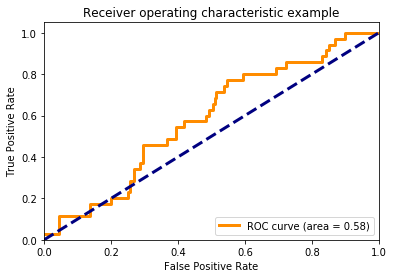

In [48]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(test_set_labels.shape[1]):
    fpr[i], tpr[i], _ = roc_curve(test_set_labels[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
    
fpr["micro"], tpr["micro"], _ = roc_curve(test_set_labels.ravel(), predictions.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



plt.figure()
lw = 3
label = 28
plt.plot(fpr[label], tpr[label], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[label])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [109]:
import math
weights = np.concatenate([ i.flatten() for i in model.get_weights() ])
print('Are there NaN weights? {}'.format(any([ math.isnan(i) for i in weights])))

Are there NaN weights? False
